# FFNN for Multiclass DICOM CT Scan Classification

Includes:
- DICOM loading from structured folders
- Exclusion of True Benign (TB)
- Image augmentation
- Multiclass FFNN

In [153]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import random
import seaborn as sns

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from albumentations import HorizontalFlip, VerticalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, CoarseDropout
import albumentations as A

from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import SimpleITK as sitk
from scipy.ndimage import zoom 
from sklearn.preprocessing import LabelEncoder


#Code from existing github repo provided by UC Irvine dataset
from utils.equalizer import histEq
from utils.utils import cutCube


In [154]:
# Modified DICOM loading functions for newer pydicom versions
def load_scan(path2scan):
    if (path2scan.split('.')[-1] == 'mhd') or (path2scan.split('.')[-1] == 'raw'):
        return load_mhd(path2scan)
    elif path2scan.split('.')[-1] == 'dcm':
        return load_dicom(os.path.split(path2scan)[0]) #pass containing directory
    elif os.path.isdir(path2scan) and any(f.endswith('.dcm') for f in os.listdir(path2scan)):
        return load_dicom(path2scan)
    else:
        raise Exception('No valid scan [series] found in given file/directory')

def load_mhd(path2scan):
    itkimage = sitk.ReadImage(path2scan)
    scan = sitk.GetArrayFromImage(itkimage)
    spacing = np.flip(np.array(itkimage.GetSpacing()),axis=0)
    orientation = np.transpose(np.array(itkimage.GetDirection()).reshape((3, 3)))
    origin = np.flip(np.array(itkimage.GetOrigin()),axis=0)
    return scan, spacing, orientation, origin, None

def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
    if not dcms:
        raise Exception(f"No DICOM files found in {dicom_folder}")
    
    first_slice_data = pydicom.dcmread(os.path.join(path2scan_dir, dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient)
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]])

    scan = np.zeros((len(dcms), first_slice.shape[0], first_slice.shape[1]))
    raw_slices = []
    indexes = []
    
    for dcm in dcms:
        slice_data = pydicom.dcmread(os.path.join(dicom_folder, dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    
    indexes = np.array(indexes, dtype=float)
    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    
    try:
        origin = np.array(raw_slices[0][0x00200032].value)
        origin = np.array([origin[2], origin[1], origin[0]])
    except:
        origin = np.zeros(3)

    for i, slice_obj in enumerate(raw_slices):
        scan[i, :, :] = slice_obj.pixel_array
    
    return scan, spacing, orientation, origin, raw_slices

def scale_scan(scan, spacing, factor=1):
    resize_factor = factor * spacing
    new_real_shape = scan.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / scan.shape
    new_spacing = spacing / real_resize_factor
    scan_resized = scipy.ndimage.zoom(scan, real_resize_factor, mode='nearest')
    return scan_resized, resize_factor

def get_scaled_shape(shape, spacing):
    new_real_shape = shape * spacing
    return np.round(new_real_shape).astype(int)

def world2vox(world_coord, spacing, orientation, origin):
    world_coord = np.dot(np.linalg.inv(np.dot(orientation, np.diag(spacing))), world_coord - origin)
    if orientation[0, 0] < 0:
        vox_coord = (np.array([world_coord[0], world_coord[2], world_coord[1]])).astype(int)
    else:
        vox_coord = (np.array([world_coord[0], world_coord[1], world_coord[2]])).astype(int)
    return vox_coord

In [155]:
class LabeledExtractor:
    """
    Adapted extractor for labeled medical imaging dataset to meet new pydicom requirements
    """
    def __init__(self, 
                 labels_csv_path, 
                 dicom_base_dir, 
                 dst_path, 
                 norm_save_dir,
                 cube_shape=(32, 32, 32),
                 parallelize=False,
                 coordSystem='vox',
                 include_types=['FB', 'FM', 'TM'], 
                 augment=True):
        """
        Args:
            labels_csv_path: Path to labels file
            dicom_base_dir: Base directory containing DICOM scans organized by uuid
            dst_path: Where to save the processed dataset
            norm_save_dir: Where to save normalization parameters
            cube_shape: Size of extracted 3D cubes
            parallelize: Whether to use multiprocessing
            coordSystem: 'vox' for voxel coordinates
            include_types: Which finding types to include
            augment: Whether to perform data augmentation
        """
        self.labels_csv_path = labels_csv_path
        self.dicom_base_dir = dicom_base_dir
        self.dst_path = dst_path
        self.norm_save_dir = norm_save_dir
        self.cube_shape = cube_shape
        self.parallelize = parallelize
        self.coordSystem = coordSystem
        self.include_types = include_types
        self.augment = augment
        
        # Load and filter the labels
        self.labels_df = pd.read_csv(labels_csv_path)
        self.labels_df = self.labels_df[self.labels_df['type'].isin(include_types)]
        
        # Filter out TB entries with 0,0,0 coordinates (no specific location)
        self.labels_df = self.labels_df[~((self.labels_df['type'] == 'TB') & 
                                        (self.labels_df['x'] == 0) & 
                                        (self.labels_df['y'] == 0) & 
                                        (self.labels_df['slice'] == 0))]
        
        print(f"Loaded {len(self.labels_df)} labeled samples")
        print(f"Types distribution:\n{self.labels_df['type'].value_counts()}")

    def extract(self, plot=True):
        """Extract and process all labeled samples"""
        print("Preparing extraction jobs...")
        
        jobs = []
        labels = []
        
        for idx, row in self.labels_df.iterrows():
            # Build path to DICOM scan
            scan_path = os.path.join(self.dicom_base_dir, str(row['uuid']))
            
            # Coordinate in z,y,x format (slice, y, x)
            coord = np.array([row['slice'], row['y'], row['x']])
            
            # Job format: [scan_path, coord, cube_shape, coordSystem, label_type]
            jobs.append([scan_path, coord, self.cube_shape, self.coordSystem, row['type']])
            labels.append(row['type'])
        
        print(f"Extracting {len(jobs)} samples...")
        
        if self.parallelize:
            num_cores = int(np.ceil(min(np.ceil(multiprocessing.cpu_count() * 0.75), len(jobs))))
            results = Parallel(n_jobs=num_cores)(delayed(self._process_job)(job) for job in jobs)
        else:
            results = []
            for i, job in enumerate(jobs):
                try:
                    result = self._process_job(job)
                    results.append(result)
                    if i % 10 == 0:
                        print(f"Processed {i+1}/{len(jobs)} samples")
                except Exception as e:
                    print(f"Failed to process sample {job[0]}: {e}")
                    results.append(None)
        
        # Collect successful extractions
        instances = []
        instance_labels = []
        
        for i, result in enumerate(results):
            if result is not None:
                cubes, label_type = result
                instances.extend(cubes)
                instance_labels.extend([label_type] * len(cubes))
        
        instances = np.array(instances)
        instance_labels = np.array(instance_labels)
        
        if len(instances) == 0:
            print("ERROR: No instances were successfully extracted!")
            print("This could be due to:")
            print("1. DICOM loading issues")
            print("2. Coordinate problems")
            print("3. Missing DICOM files")
            return None, None, None
        
        print(f"Successfully extracted {len(instances)} instances")
        
        # Preprocessing
        print("Equalizing the data...")
        eq = histEq(instances)
        instances = eq.equalize(instances)
        os.makedirs(self.norm_save_dir, exist_ok=True)
        eq.save(path=os.path.join(self.norm_save_dir, 'equalization.pkl'))

        print("Normalizing the data...")
        min_v = np.min(instances)
        max_v = np.max(instances)
        mean_v = np.mean(instances)
        norm_data = np.array([mean_v, min_v, max_v])
        instances = (instances - mean_v) / (max_v - min_v)
        np.save(os.path.join(self.norm_save_dir, 'normalization.npy'), norm_data)

        if plot:
            self._plot_samples(instances, instance_labels)

        # Save dataset and labels
        print("Saving the dataset...")
        np.save(self.dst_path, instances)
        np.save(self.dst_path.replace('.npy', '_labels.npy'), instance_labels)
        
        # Create label mapping
        label_mapping = {label: idx for idx, label in enumerate(np.unique(instance_labels))}
        print(f"Label mapping: {label_mapping}")
        
        return instances, instance_labels, label_mapping

    def _process_job(self, args):
        """Process single extraction job"""
        scan_path, coord, cube_shape, coordSystem, label_type = args
        
        try:
            # Load scan
            scan, spacing, orientation, origin, raw_slices = load_scan(scan_path)
            
            # Convert coordinates if needed
            if coordSystem == 'world':
                coord = world2vox(coord, spacing, orientation, origin)
            
            # Extract the base cube with padding
            init_cube_shape = get_scaled_shape(np.array(cube_shape) + 8, 1/spacing)
            clean_cube_unscaled = cutCube(scan, coord, init_cube_shape, padd=-1000)
            
            # Scale the cube
            scaled_cube, resize_factor = scale_scan(clean_cube_unscaled, spacing)
            
            # Data augmentation
            if self.augment:
                augmented_cubes = self._augment_instance(scaled_cube)
            else:
                augmented_cubes = [scaled_cube]
            
            # Trim to final shape
            final_cubes = []
            for cube in augmented_cubes:
                center = np.array(cube.shape) // 2
                final_cube = cutCube(cube, center, cube_shape, padd=-1000)
                if final_cube.shape == tuple(cube_shape):  # Only keep properly shaped cubes
                    final_cubes.append(final_cube)
            
            return final_cubes, label_type
            
        except Exception as e:
            print(f"Error processing {scan_path}: {e}")
            return None

    def _augment_instance(self, x0):
        """Data augmentation similar to original code but simplified"""
        augmented = [x0]  # Original
        
        # Flips
        augmented.append(np.flip(x0, 1))  # x flip
        augmented.append(np.flip(x0, 2))  # y flip
        
        # Small shifts
        augmented.append(scipy.ndimage.shift(x0, (0, 2, 2), mode='constant'))
        augmented.append(scipy.ndimage.shift(x0, (0, -2, 2), mode='constant'))
        
        # Small rotations
        for angle in [15, 30, 45, 90, 180]:
            rotated = rotate(x0, angle, axes=(1, 2), mode='reflect', reshape=False)
            augmented.append(rotated)
        
        # Filter out invalid shapes
        valid_cubes = []
        for cube in augmented:
            if cube.shape[0] > 0 and cube.shape[1] > 0 and cube.shape[2] > 0:
                valid_cubes.append(cube)
        
        return valid_cubes

    def _plot_samples(self, instances, labels):
        """Plot sample instances with their labels"""
        import matplotlib.pyplot as plt
        
        # Select random samples from each class
        unique_labels = np.unique(labels)
        samples_per_class = min(5, len(instances) // len(unique_labels))
        
        fig, axes = plt.subplots(len(unique_labels), samples_per_class, 
                                figsize=(samples_per_class * 3, len(unique_labels) * 3))
        
        if len(unique_labels) == 1:
            axes = axes.reshape(1, -1)
        
        for i, label in enumerate(unique_labels):
            label_indices = np.where(labels == label)[0]
            selected_indices = np.random.choice(label_indices, 
                                              min(samples_per_class, len(label_indices)), 
                                              replace=False)
            
            for j, idx in enumerate(selected_indices):
                middle_slice = instances[idx].shape[0] // 2
                axes[i, j].imshow(instances[idx][middle_slice, :, :], cmap='bone')
                axes[i, j].set_title(f'{label}')
                axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Sample Extracted Instances by Type')
        plt.show()


In [156]:
class LabeledDataLoader:
    """
    Data loader for labeled dataset - modified for classification
    """
    def __init__(self, dataset_path, labels_path, normdata_path, img_res=(32, 32, 32)):
        self.normdata_path = normdata_path
        self.img_res = img_res
        
        print("Loading preprocessed dataset...")
        self.data = np.load(dataset_path)
        self.labels = np.load(labels_path)
        
        # Create label mapping
        self.unique_labels = np.unique(self.labels)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        
        # Convert labels to indices
        self.label_indices = np.array([self.label_to_idx[label] for label in self.labels])
        
        # Format for neural network
        self.data = self.data.reshape((len(self.data), self.img_res[0], self.img_res[1], self.img_res[2], 1))
        
        print(f"Loaded {len(self.data)} samples")
        print(f"Label distribution: {dict(zip(*np.unique(self.labels, return_counts=True)))}")

    def load_batch(self, batch_size=32, shuffle=True):
        """Load batches for training"""
        if shuffle:
            indices = np.random.permutation(len(self.data))
        else:
            indices = np.arange(len(self.data))
        
        n_batches = len(self.data) // batch_size
        
        for i in range(n_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_data = self.data[batch_indices]
            batch_labels = self.label_indices[batch_indices]
            
            yield batch_data, batch_labels


Using DICOM directory: ../final_project/data/Tampered Scans/Experiment 1 - Blind
Loaded 118 labeled samples
Types distribution:
type
FB    61
FM    34
TM    23
Name: count, dtype: int64
Looking for labels at: ../final_project/data/Tampered Scans/labels_exp1.csv
Looking for DICOM scans at: ../final_project/data/Tampered Scans/Experiment 1 - Blind
Preparing extraction jobs...
Extracting 118 samples...
Processed 1/118 samples
Processed 11/118 samples
Processed 21/118 samples
Processed 31/118 samples
Processed 41/118 samples
Processed 51/118 samples
Processed 61/118 samples
Processed 71/118 samples
Processed 81/118 samples
Processed 91/118 samples
Processed 101/118 samples
Processed 111/118 samples
Successfully extracted 1180 instances
Equalizing the data...
Normalizing the data...


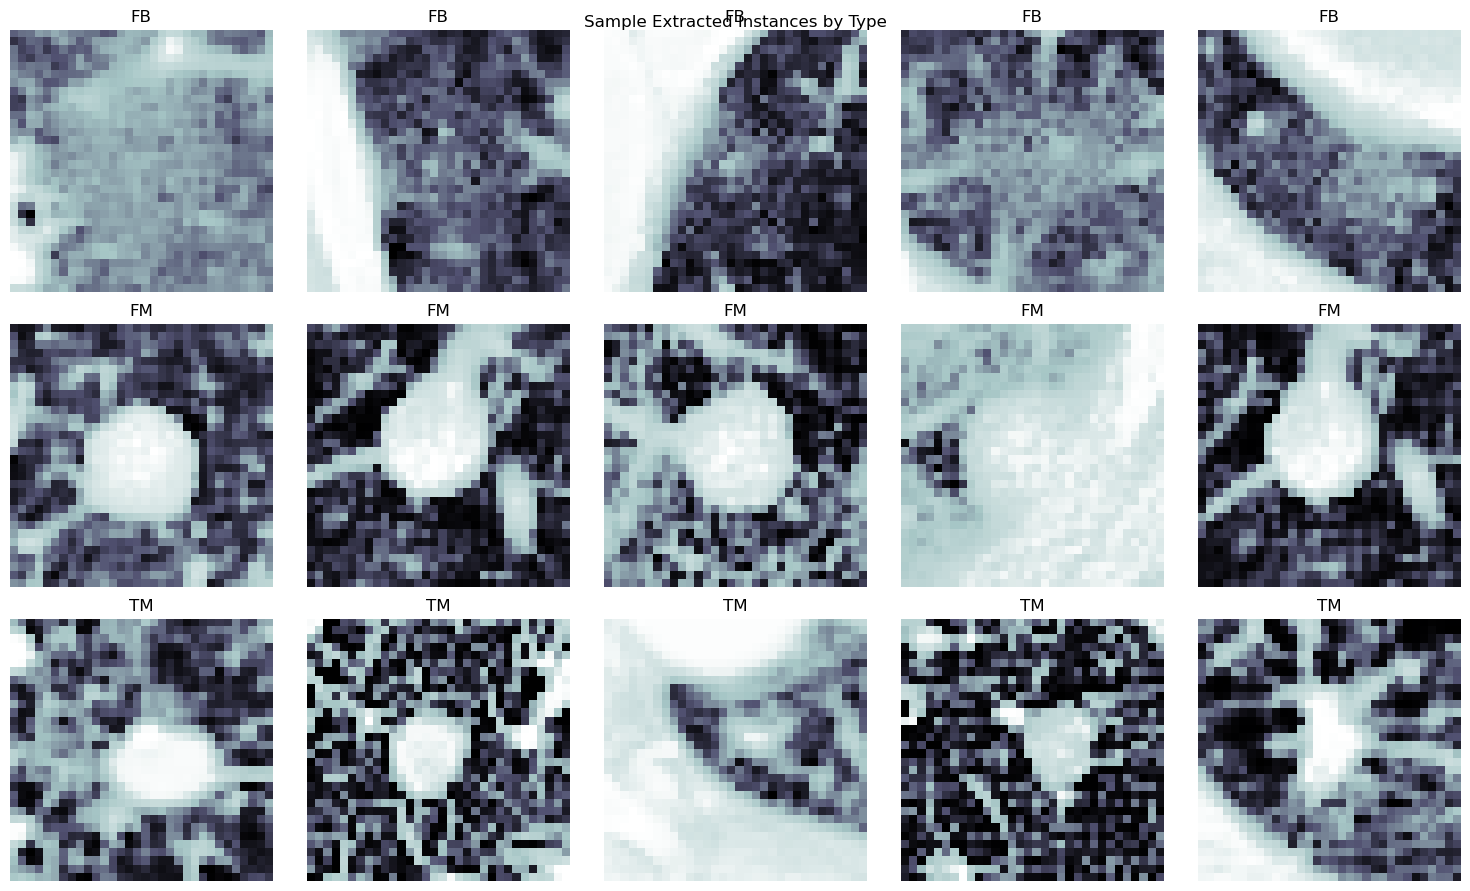

Saving the dataset...
Label mapping: {'FB': 0, 'FM': 1, 'TM': 2}
Loading preprocessed dataset...
Loaded 1180 samples
Label distribution: {'FB': 610, 'FM': 340, 'TM': 230}
Label mapping: {'FB': 0, 'FM': 1, 'TM': 2}


In [157]:
# Configuration for dicom dataset (make sure you change to your Windows path if you want to run it)
base_path = os.path.expanduser("../final_project/data/Tampered Scans/")
labels_csv = os.path.join(base_path, "labels_exp1.csv")

# DICOM in the "Experiment 1 - Blind" subdirectory
dicom_dir = os.path.join(base_path, "Experiment 1 - Blind")


print(f"\nUsing DICOM directory: {dicom_dir}")

output_dataset = "tampered_scans_dataset.npy"
normalization_dir = "tampered_scans_normalization"

# Extract and preprocess
extractor = LabeledExtractor(
    labels_csv_path=labels_csv,
    dicom_base_dir=dicom_dir,
    dst_path=output_dataset,
    norm_save_dir=normalization_dir,
    cube_shape=(32, 32, 32),
    include_types=['FB', 'FM', 'TM'], 
    augment=True,
    parallelize=False  
)

print(f"Looking for labels at: {labels_csv}")
print(f"Looking for DICOM scans at: {dicom_dir}")

    
instances, labels, label_mapping = extractor.extract()

# Load for training
dataloader = LabeledDataLoader(
    dataset_path=output_dataset,
    labels_path=output_dataset.replace('.npy', '_labels.npy'),
    normdata_path=normalization_dir
)

print(f"Label mapping: {label_mapping}")

In [158]:
def create_eda_dataframe(labels_csv_path, processed_data_path=None, processed_labels_path=None):
    """
    Create dataframe for EDA
    """
    # Load original labels CSV
    print("Loading original labels...")
    df_original = pd.read_csv(labels_csv_path)
    
    # Filter out TB entries with 0,0,0 coordinates 
    df_filtered = df_original[df_original['type'].isin(['FB', 'FM', 'TM'])]
    df_filtered = df_filtered[~((df_filtered['type'] == 'TB') & 
                              (df_filtered['x'] == 0) & 
                              (df_filtered['y'] == 0) & 
                              (df_filtered['slice'] == 0))]
    
    print(f"Original labels: {len(df_original)}")
    print(f"After filtering: {len(df_filtered)}")
    
    # Add encoded labels for visualization
    le = LabelEncoder()
    df_filtered['type_encoded'] = le.fit_transform(df_filtered['type'])
    
    # add augmentation info
    if processed_data_path and processed_labels_path:
        try:
            processed_labels = np.load(processed_labels_path)
            print(f"Processed dataset size: {len(processed_labels)}")
            
            # Calculate augmentation factor
            augmentation_factor = len(processed_labels) / len(df_filtered)
            df_filtered['augmentation_factor'] = augmentation_factor
            
        except FileNotFoundError:
            print("Processed data not found, using original data only")
            df_filtered['augmentation_factor'] = 1
    
    return df_filtered, le

In [159]:
# Just to grab the data to look at our distribution
labels_csv = "../final_project/data/Tampered Scans/labels_exp1.csv"
processed_data = "tampered_scans_dataset.npy"
processed_labels = "tampered_scans_dataset_labels.npy"

# Run the complete EDA
df, label_encoder = create_eda_dataframe(
    labels_csv_path=labels_csv,
    processed_data_path=processed_data,
    processed_labels_path=processed_labels
)

print(df.shape)
print(df['type'].unique())

Loading original labels...
Original labels: 133
After filtering: 118
Processed dataset size: 1180
(118, 7)
['FB' 'FM' 'TM']


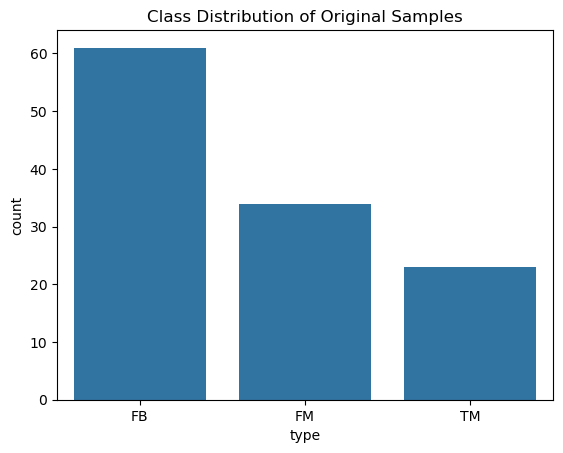

,type,uuid,slice,x,y,type_encoded,augmentation_factor
0,FB,1280,100,323,381,0,10.0
1,FB,1009,76,354,288,0,10.0
2,FB,7794,79,163,191,0,10.0
3,FB,7794,94,338,243,0,10.0
4,FB,2997,45,156,135,0,10.0


In [160]:
# Plot Distribution
sns.countplot(data=df, x="type")
plt.title('Class Distribution of Original Samples')
plt.show()

df.head()

In [203]:
# Load in images to X and labels as Y
X = np.load(processed_data)
Y = np.load(processed_labels)

# Grab middle slices as cubes are already centered around the node of issue
middle_slices = X[:, 16, :, :]
X_images = middle_slices[:,:,:,np.newaxis]
X_images.shape

# Flatten out the image
X_flat = X_images.reshape(X_images.shape[0], -1)

# Encode the Y to integers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Split off test (20%) from the full dataset
X_temp, X_test, Y_temp, Y_test = train_test_split(X_flat, Y_encoded, test_size=0.2, random_state=1234)

# Split remaining 80% into train (60%) and val (20%)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=1234)

# Print Shapes
print(f'Shape of training dataset: {X_train.shape}, {Y_train.shape}')
print(f'Shape of test dataset: {X_test.shape}, {Y_test.shape}')
print(pd.DataFrame(Y).head())
print(X[0])

Shape of training dataset: (708, 1024), (708,)
Shape of test dataset: (236, 1024), (236,)
    0
0  FB
1  FB
2  FB
3  FB
4  FB
[[[ 3.03222341e-01  2.66224131e-01  1.87649138e-01 ... -4.42847082e-01
    1.11109795e-01  2.71181450e-01]
  [ 2.77022488e-01  2.35661582e-01  2.26542732e-01 ... -4.14082000e-01
    2.56617786e-01  3.08514216e-01]
  [ 2.03668031e-01  9.10064722e-02 -1.91137813e-01 ... -2.74810600e-05
    2.81698880e-01  3.01721228e-01]
  ...
  [ 4.74538248e-01  4.79405034e-01  4.72706753e-01 ...  5.33475325e-02
    2.01010215e-02  3.80370368e-02]
  [ 4.64019107e-01  4.73022840e-01  4.74379904e-01 ...  7.78646305e-03
    1.19754035e-01  2.01831451e-01]
  [ 4.65194437e-01  4.59248184e-01  4.42484173e-01 ...  2.69910602e-01
    2.92000016e-01  3.12714301e-01]]

 [[ 2.31852649e-01 -1.01006513e-01 -2.16022492e-01 ... -4.61481354e-01
   -2.75269112e-01  1.12669956e-01]
  [ 1.45479230e-01 -3.42709643e-02  7.68960852e-02 ... -4.29593568e-01
   -2.68907255e-01  1.89862181e-01]
  [-3.2592

In [204]:
# Add Class weights to balance out the distribution
raw_labels = np.array(Y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(raw_labels), y=raw_labels)
class_weight_dict = dict(enumerate(class_weights))


print("Class Weights:", class_weight_dict)
print(type(class_weight_dict))

Class Weights: {0: 0.6378378378378379, 1: 1.18, 2: 1.710144927536232}
<class 'dict'>


In [205]:
# Check shapes before running in the FFNN model
print(X_flat.shape)
print(X_train.shape)  # should be (944, 32768)
print(X_test.shape)
print(Y_train.shape)  # should be (944,)
print(np.unique(Y_train))  # should be [0 1 2]
print(class_weight_dict) # should look like: {0: ..., 1: ..., 2: ...}
print(X_flat.shape[1],)


(1180, 1024)
(708, 1024)
(236, 1024)
(708,)
[0 1 2]
{0: 0.6378378378378379, 1: 1.18, 2: 1.710144927536232}
1024


In [207]:
# Build FFNN
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_flat.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)


In [208]:
# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4428 - loss: 1.2642 - val_accuracy: 0.6356 - val_loss: 0.9571
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4924 - loss: 1.0598 - val_accuracy: 0.6059 - val_loss: 0.9249
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5044 - loss: 1.0081 - val_accuracy: 0.6229 - val_loss: 0.8899
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5509 - loss: 0.9096 - val_accuracy: 0.6441 - val_loss: 0.8494
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5717 - loss: 0.9214 - val_accuracy: 0.6653 - val_loss: 0.8194
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5703 - loss: 0.8567 - val_accuracy: 0.6780 - val_loss: 0.7834
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6542 - loss: 0.8317 - val_accuracy: 0.7331 - val_loss: 0.7510
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6436 - loss: 0.7888 - val_accuracy: 0.7500 - val_loss:

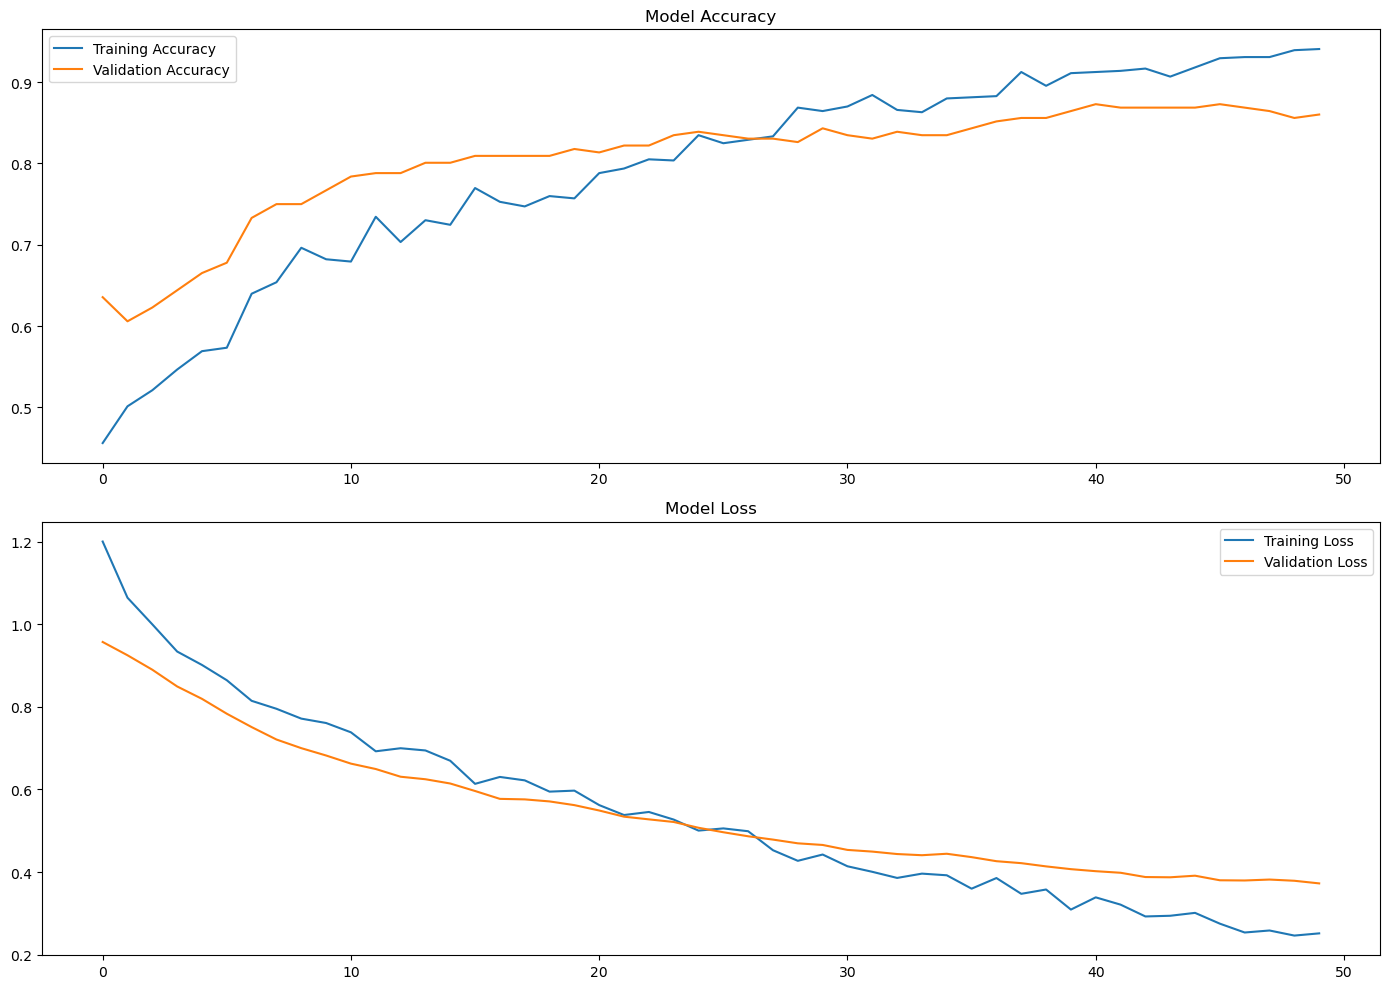

In [209]:
# Plot training history
fig, axs = plt.subplots(2, figsize=(14, 10))

# Accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].legend()


plt.tight_layout()
plt.show()


Final Training Loss: 0.2515
Final Training Accuracy: 0.9407
Final Validation Loss: 0.3725
Final Validation Accuracy: 0.8602
              precision    recall  f1-score   support

          FB       0.95      0.91      0.93       115
          FM       0.84      0.97      0.90        73
          TM       0.72      0.60      0.66        48

    accuracy                           0.87       236
   macro avg       0.84      0.83      0.83       236
weighted avg       0.87      0.87      0.86       236

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


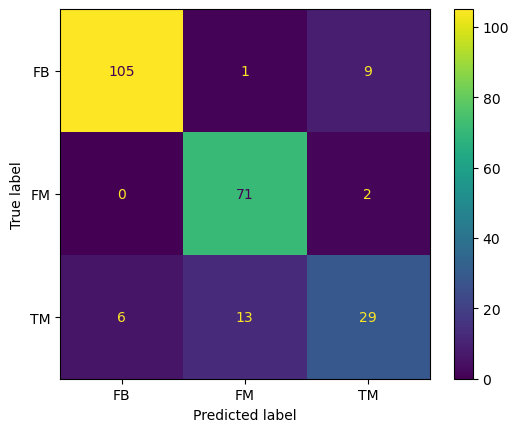

In [ ]:
# Print final training accuracy and loss
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]

# Print final validation accuracy and loss
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


# Set up the model via the test set
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = Y_test

# Print the Precision and Recall
print(classification_report(y_true, y_pred, target_names=["FB", "FM", "TM"]))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FB", "FM", "TM"])
disp.plot()
plt.show()